In [35]:
import tqdm
import json
import pandas as pd
import requests

SHEET_ID = '1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4'
SHEET_TABS = {
    'REGISTROS': 2103959160,
    'USUARIOS': 102021014,
}
REGISTROS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["REGISTROS"]}'
USUARIOS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["USUARIOS"]}'

# Vamos a hacer un grafo por carrera... hay que setupearla aca!
# sistemas informatica agrimensura alimentos civil electricista electronica 
# industrial mecanica naval petroleo quimica sistemasviejo
CARRERA = 'informatica'

In [36]:
# Empezamos cargando todos los datos (los usuarios y los mapas estan en dos tablas distintas)
df_registros = pd.read_csv(REGISTROS_URL)
df_registros.drop("Timestamp", axis=1, inplace=True)
df_registros.dropna(inplace=True, how="any")
df_registros = df_registros[df_registros['Carrera'] == CARRERA]
display(df_registros.sample(3))

df_usuarios = pd.read_csv(USUARIOS_URL)
df_usuarios.drop("Timestamp", axis=1, inplace=True)
df_usuarios.dropna(inplace=True, how="all")
df_usuarios = df_usuarios[df_usuarios['Carrera'] == CARRERA]
display(df_usuarios.sample(3))

Padron      Carrera                                               Mapa
2797  104239  informatica  {"materias":[{"id":"CBC","nota":0},{"id":"62.0...
50    109638  informatica  {"materias":[{"id":"75.40","nota":8}],"optativ...
2542  102439  informatica  {"materias":[{"id":"CBC","nota":0},{"id":"62.0...

Padron      Carrera            Orientacion Final de Carrera
7169            00000  informatica                    NaN              NaN
10974  fedeesuncapofg  informatica                    NaN            tesis
1397           102184  informatica  Sistemas Distribuidos              tpp

In [37]:
### Testing purposes: en vez de laburar con toooodos los datos, laburemos solo con los integrantes del grupo
# df_usuarios = df_usuarios[df_usuarios['Padron'].isin(["100029", "101696", "101109", "0000"])]

In [38]:
# Mergeamos!
df_mergeado = df_usuarios.merge(df_registros)
df_mergeado.sample(3)

Padron      Carrera                     Orientacion Final de Carrera  \
655   92558  informatica  Gestión Industrial de Sistemas              tpp   
427  104354  informatica                             NaN              NaN   
405  109704  informatica                             NaN            tesis   

                                                  Mapa  
655  {"materias":[{"id":"CBC","nota":0},{"id":"62.0...  
427  {"materias":[{"id":"CBC","nota":0,"cuatri":-1}...  
405  {"materias":[{"id":"CBC28","nota":6},{"id":"CB...

In [39]:
df_mergeado.describe()

Padron      Carrera            Orientacion Final de Carrera  \
count      947          947                    546              560   
unique     947            1                      3                2   
top     109164  informatica  Sistemas Distribuidos              tpp   
freq         1          947                    275              432   

                                                     Mapa  
count                                                 947  
unique                                                846  
top     {"materias":[{"id":"CBC","nota":0,"cuatri":-1}...  
freq                                                   39

In [40]:
# Ahora, desempaquetamos la columna "Mapa" (un JSON que contiene notas, metadata, de todo...) 
#   y finalmente lleguemos al df que vamos a usar durante todo el tp

df = df_mergeado
new_df = pd.DataFrame()
for idx in tqdm.tqdm(df.index):
    json_mapa = json.loads(df.loc[idx]['Mapa'])
    
    for k in json_mapa.keys():
        if not json_mapa[k]: 
            continue
        if k == "materias":
            df_json = pd.json_normalize(json_mapa, k, record_prefix="materia_")
        else:
            df_json = pd.DataFrame({k: [json_mapa[k]]})
        df_json["Padron"] = df.loc[idx]['Padron']
        new_df = pd.concat([new_df, df_json])

df = df.merge(new_df, how="outer")
df.drop('Mapa', axis=1, inplace=True)
# Hace mucho tiempo, el fiuba map tenia un feature que se llamaba "materia_cuatri" (en vez del nuevo "materia_cuatrimestre")
# En donde el usuario seteaba en cuantos N cuatris iba a cursar X materia, en vez de setear el cuatri exacto
# Como ya no se usa en el upstream, no es lo correcto que lo utilicemos en el analisis de datos
# df.drop('materia_cuatri', axis=1, inplace=True)
df.sample(3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 947/947 [00:03<00:00, 305.81it/s]


Padron      Carrera                     Orientacion Final de Carrera  \
7684   100052  informatica          Sistemas de Producción              tpp   
789    100849  informatica  Gestión Industrial de Sistemas              tpp   
18555  103878  informatica                             NaN              NaN   

      materia_id  materia_nota  materia_cuatrimestre optativas  aplazos  \
7684       75.44           9.0                   NaN       NaN      NaN   
789        71.40          -2.0                2021.5       NaN      NaN   
18555      61.08          10.0                2021.5       NaN      NaN   

       materia_cuatri  
7684              NaN  
789               NaN  
18555             NaN

In [41]:
# Vamos a armar un grafazo: Analizar "camadas" de gente -> cursaron juntos y les fue parecido en la facu
# nodos -> usuarios
# flechas -> cursar misma materia mismo cuatri
# TODO: peso de flechas -> correlacion entre notas(???)
# Ejemplo de conexion:

df_nodes_metadata = df[["Padron", "Carrera", "aplazos", "optativas"]]#, "checkboxes"]]
df_nodes_metadata = df_nodes_metadata[df_nodes_metadata["aplazos"].notnull() | df_nodes_metadata["optativas"].notnull()]
df_nodes_metadata = df_nodes_metadata.groupby(["Padron", "Carrera"], as_index=False).first()

df_nodes = df[["Padron", "Carrera", "Orientacion", "Final de Carrera"]]
df_nodes = df_nodes.drop_duplicates()
df_nodes = df_nodes.merge(df_nodes_metadata, how="outer")
df_nodes.set_index("Padron", inplace=True)
display(df_nodes.sample(3))

from itertools import combinations
df_edges = (df[df['materia_cuatrimestre'].notnull()]
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

df_edges = df_edges.reset_index()
df_edges[['src', 'dst']] = df_edges['Usuarios'].tolist()
df_edges[['src_padron', 'src_nota']] = df_edges['src'].tolist()
df_edges[['dst_padron', 'dst_nota']] = df_edges['dst'].tolist()
df_edges = df_edges[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]
display(df_edges.sample(3))

Carrera                     Orientacion Final de Carrera  aplazos  \
Padron                                                                          
80450   informatica           Sistemas Distribuidos            tesis      NaN   
100839  informatica           Sistemas Distribuidos              tpp      NaN   
104393  informatica  Gestión Industrial de Sistemas              tpp      NaN   

       optativas  
Padron            
80450        NaN  
100839       NaN  
104393       NaN

/tmp/ipykernel_35710/2502229575.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


src_padron dst_padron  materia_cuatrimestre materia_id src_nota dst_nota
45085     100901     100680                2021.5      71.40     -2.0     -1.0
93049     105854     105604                2022.0      75.29     10.0      9.0
5240       98592     107115                2020.5      61.03      5.0     -1.0

In [42]:
import networkx as nx
G = nx.from_pandas_edgelist(df_edges, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

nx.set_node_attributes(G, df_nodes.to_dict('index'))
print(G)

MultiGraph with 383 nodes and 129715 edges


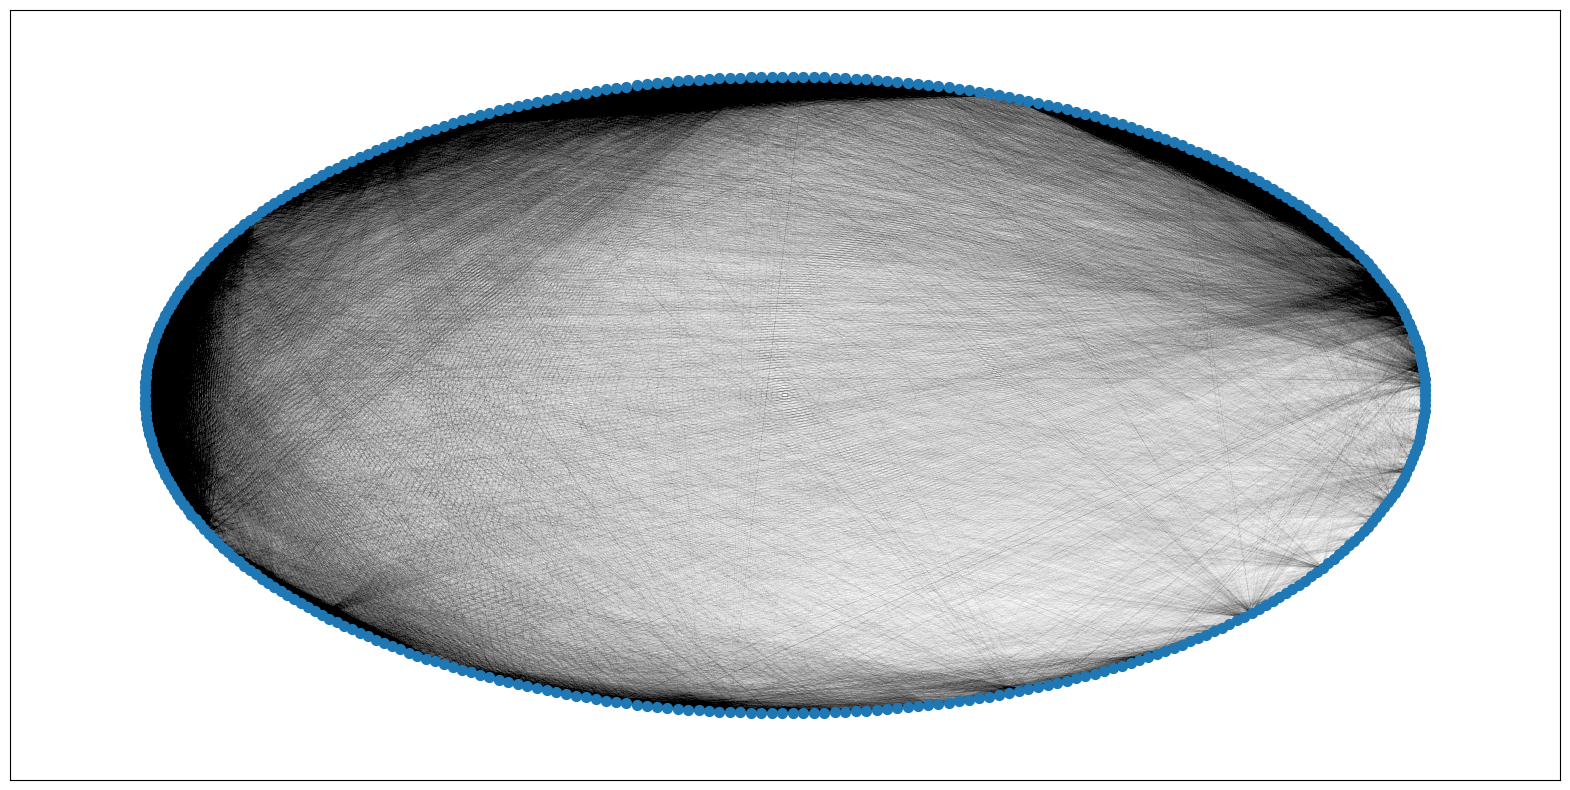

In [43]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

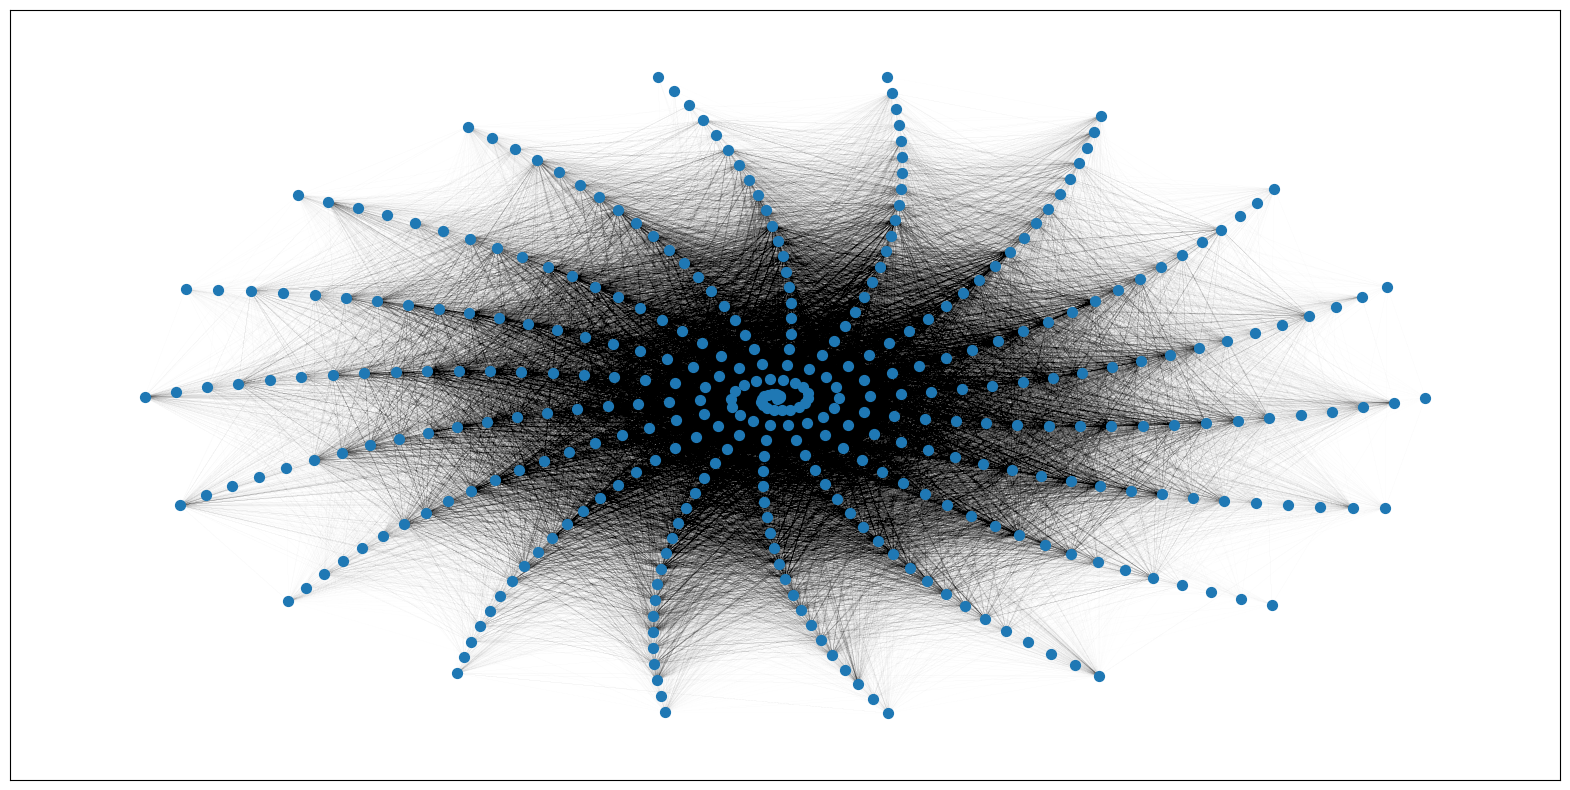

In [45]:
# Again!
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.spiral_layout(G), width=0.005, node_size=50, with_labels=False)

In [46]:
# # Solo como demo: ahora veamos el grafo, pero dibujemos todas las aristas
# # Robadisimo de: https://stackoverflow.com/a/60638452
# pos = nx.random_layout(G)
# nx.draw_networkx_nodes(G, pos)
# ax = plt.gca()
# for e in G.edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="-", color="0.5",
#                                 connectionstyle="arc3,rad=rr".replace('rr',str(0.3*e[2]))),
#                 )
# plt.axis('off')
# plt.show()

In [ ]:
### Hasta acá refactorizo Fede

In [47]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 4
  El grado promedio de la red: 677.36
  TODO: Los allegados promedio de la red: 
  Puentes globales: [('98439', '99796')]



In [48]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

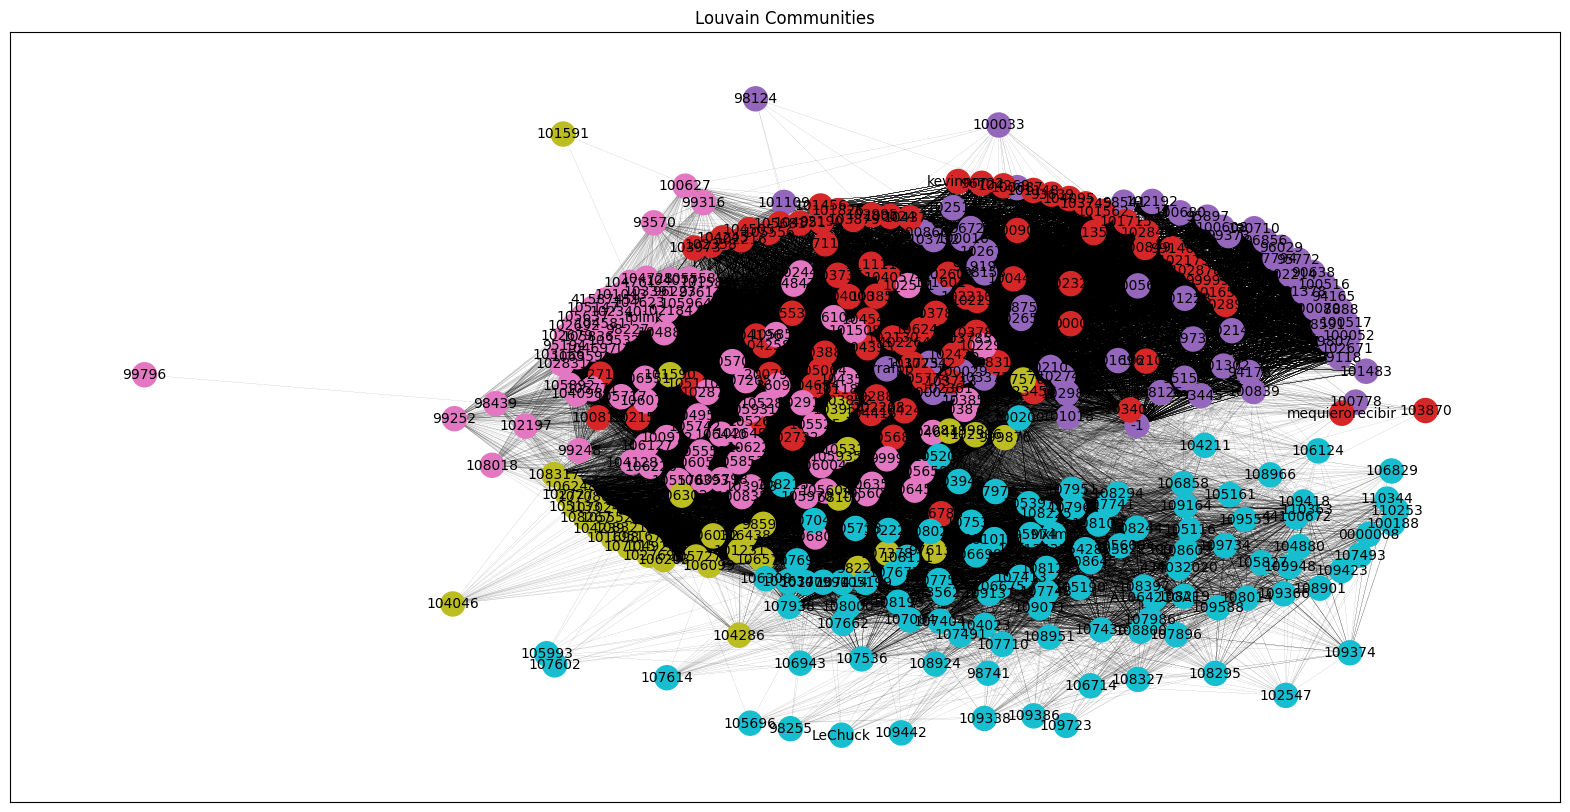

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

In [50]:
# Todo: sacar distribucion de padrones de cada comunidad, para poder clasificar
# as in "esta es la comunidad de los jovenes, esta es la de los viejos, esta no tiene patron, etc"
louvain

[{'-1',
  '100016',
  '100029',
  '100033',
  '100052',
  '100070',
  '100073',
  '100516',
  '100517',
  '100560',
  '100608',
  '100680',
  '100687',
  '100710',
  '100778',
  '100839',
  '100866',
  '101018',
  '101109',
  '101228',
  '101302',
  '101483',
  '101601',
  '101696',
  '102103',
  '102140',
  '102192',
  '102214',
  '102342',
  '102361',
  '102510',
  '102654',
  '102671',
  '102674',
  '102740',
  '102981',
  '103371',
  '103732',
  '8888',
  '90638',
  '91378',
  '919191',
  '93445',
  '94165',
  '94178',
  '95159',
  '95772',
  '95897',
  '96029',
  '96728',
  '96856',
  '97794',
  '98124',
  '98125',
  '98153',
  '98541',
  '98591',
  '98752',
  '99118',
  '99373',
  '99732',
  '99807',
  'fsrrafpp'},
 {'0000',
  '100445',
  '100624',
  '100815',
  '100849',
  '100901',
  '101148',
  '101187',
  '101456',
  '101562',
  '101651',
  '101715',
  '101826',
  '102102',
  '102130',
  '102150',
  '102179',
  '102208',
  '102210',
  '102216',
  '102219',
  '102264',
  '1023

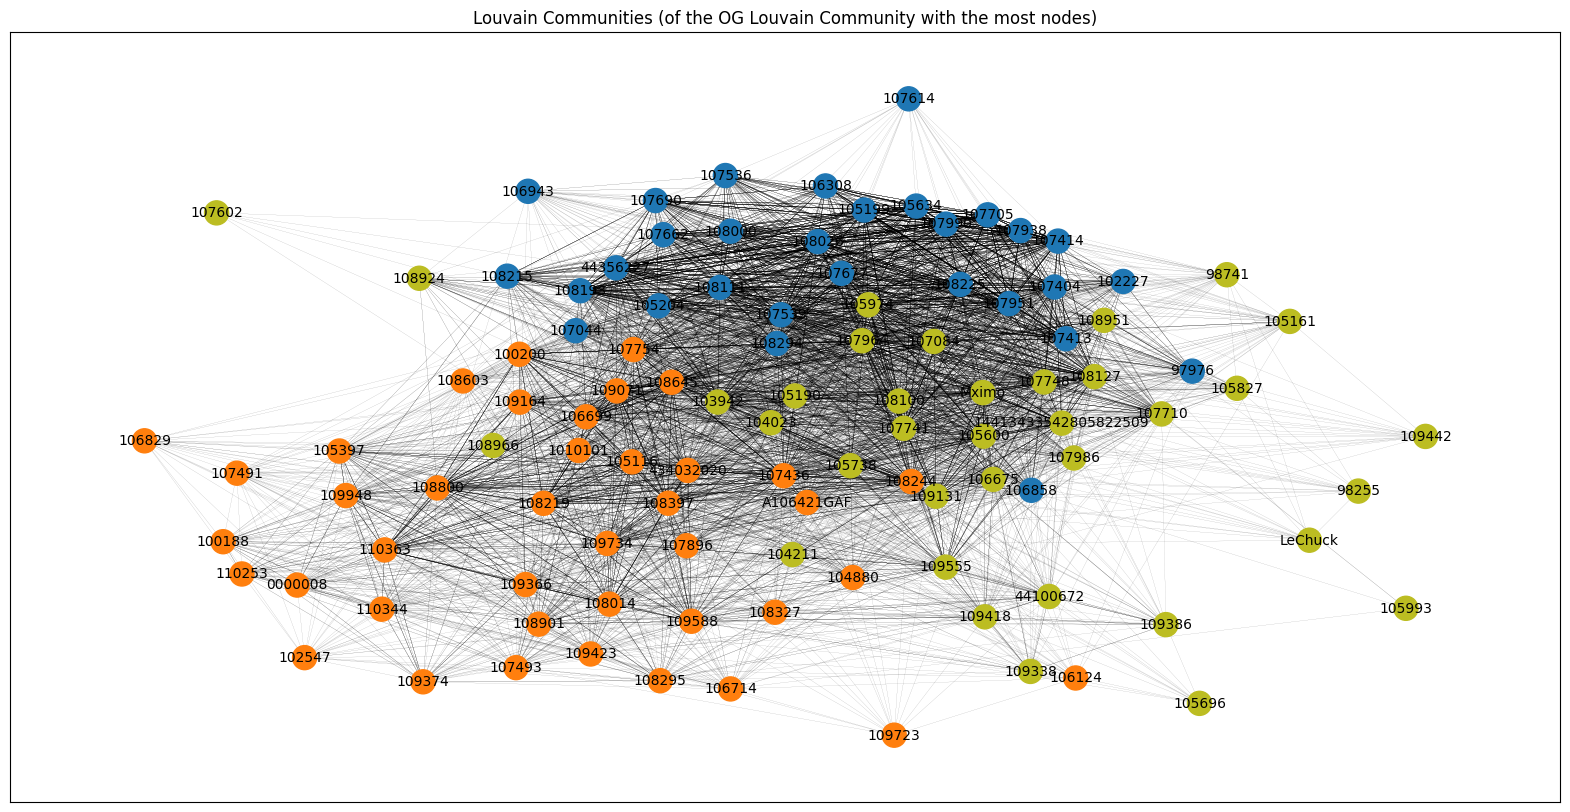

In [51]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [52]:
subnetwork_louvain

[{'0000008',
  '100188',
  '100200',
  '1010101',
  '102547',
  '104880',
  '105116',
  '105397',
  '106124',
  '106699',
  '106714',
  '106829',
  '107436',
  '107491',
  '107493',
  '107754',
  '107896',
  '108014',
  '108219',
  '108244',
  '108295',
  '108327',
  '108397',
  '108603',
  '108645',
  '108800',
  '108901',
  '109071',
  '109164',
  '109366',
  '109374',
  '109423',
  '109588',
  '109723',
  '109734',
  '109948',
  '110253',
  '110344',
  '110363',
  '434032020',
  'A106421GAF'},
 {'103942',
  '104023',
  '104211',
  '105161',
  '105190',
  '105600',
  '105696',
  '105738',
  '105827',
  '105974',
  '105993',
  '106675',
  '107084',
  '107602',
  '107710',
  '107741',
  '107748',
  '107964',
  '107986',
  '108100',
  '108127',
  '108924',
  '108951',
  '108966',
  '109131',
  '109338',
  '109386',
  '109418',
  '109442',
  '109555',
  '14413433542805822509',
  '44100672',
  '98255',
  '98741',
  'LeChuck',
  'Mximo'},
 {'102227',
  '105199',
  '105204',
  '105634',
  '

In [53]:
# todo: usar graphrole y rolx

In [54]:
# todo: ejercicio 5 de parcialito 3

In [55]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [ ]:
# Vamos a armar un grafon: Analizar "gente que haya tenido experiencias facultativas similares" -> sacamos el factor temporal 
# nodos -> usuarios
# flechas -> cursar misma materia y "les fue parecido" -> -1 (en final), 4-5, 6-7, 8-10
# flechas -> solo una flecha: haber cursado una materia y sacarse la misma nota -- peso: porcentaje de similitud de materia+nota
# de alguna manera tengo que considerar las electivas:
# - solo lo corro sobre materias electivas
# - tal vez sale natural
# - lo corres sobre todo, pero filtras en el output las electivas
# Ejemplo de conexion:

In [ ]:
# Vamos a armar un graphito: Analizar "gente que se haya armado cuatris parecidos al mio" -> Ahora tenemos factor temporal "local": No me importa que haya sido en el 2022C1, pero si me importa que las materias que curse el mismo cuatri esten en el mismo bucket
# nodos -> usuarios
# flechas -> compartir N materias el en mismo cuatri
# peso -> Cuantas materias compartimos (2, 3, 4 o 5)

In [56]:
# todo: plantear preguntas y resolverlas con comunidades o roles:
# "con quien hago tps?" -> Grafazo
# "que electivas curso?" -> Grafon
# "que cuatrimestre armo?" -> Graphito

In [ ]:
# TO DO FINAL:
# - Dividir en 4 notebooks: infra.ipynb, grafazo grafon graphito
# - Armar un README con el approach de "3 preguntas, 3 grafos"
# - El notebook de infra exporta el dataframe final (csv/pickle)
# - Los 3 notebooks de grafos hacen exactamente el mismo analisis, pero con distintas conclusiones
# - Cada notebook de grafo devuelve un __algo__ que sea util y valioso para el usuario (despues vemos como se lo proveemos)
#   y la respuesta puede ser o de comunidad o de roles, hay que ver que es lo adecuado.